In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import random

In [2]:
def filter_valid_bbox(labels, formate=None):
    labels = np.array(labels)
    valid_x_inx = labels[:, 2] > labels[:, 0]
    valid_y_inx = labels[:, 3] > labels[:, 1]
    valid_inx = np.stack([valid_x_inx, valid_y_inx], axis=1)
    valid_inx = np.all(valid_inx, axis=1)
    return valid_inx

In [50]:
def mosaic(imgs, labels, mosaic_shape: list):
    """
    mosaic four images
    :param imgs: four image list
    :param labels: list of ndarray; ndarray's shape is Nx4; bbox's format is [xmin, ymin, xmax, ymax]
    :param mosaic_shape: a list: [h, w]
    """
    assert len(imgs) == 4
    assert len(imgs) == len(labels)

    s = mosaic_shape[0] // 2
    xc, yc = [int(random.uniform(mosaic_shape[0]//4, mosaic_shape[0]*3//4)) for _ in range(2)]
    img_out = np.full(shape=mosaic_shape + [3], dtype=np.uint8, fill_value=125)
    label_out = []
    for i, img in enumerate(imgs):
        h, w = img.shape[:2]
        if i == 0:
            xmin_o, ymin_o, xmax_o, ymax_o = max(xc-w, 0), max(yc-h, 0), xc, yc
        elif i == 1:
            xmin_o, ymin_o, xmax_o, ymax_o = xc, max(yc-h, 0), min(xc+w, 2*s), yc
        elif i == 2:
            xmin_o, ymin_o, xmax_o, ymax_o = max(xc-w, 0), yc, xc, min(yc+h, 2*s)
        else:
            xmin_o, ymin_o, xmax_o, ymax_o = xc, yc, min(xc+w, 2*s), min(yc+h, 2*s)

        # 截取各子image的中心区域贴到mosaic image上
        xc_i, yc_i, w_i, h_i = w // 2, h // 2,  xmax_o-xmin_o, ymax_o-ymin_o
        detal_w_i, detal_h_i = w_i // 2, h_i // 2
        xmin_i = xc_i - detal_w_i
        ymin_i = yc_i - detal_h_i
        xmax_i = xc_i + (w_i - detal_w_i)
        ymax_i = yc_i + (h_i - detal_h_i)
        img_out[ymin_o:ymax_o, xmin_o:xmax_o] = img[ymin_i:ymax_i, xmin_i:xmax_i]
        
        # 处理label
        label = labels[i]
        # in small image
        pad_w_1, pad_w_2 = xmin_i, w - xmax_i
        pad_h_1, pad_h_2 = ymin_i, h - ymax_i
        label[:, [0, 2]] = np.clip(np.round(label[:, [0, 2]]), xmin_i, xmax_i)
        label[:, [1, 3]] = np.clip(np.round(label[:, [1, 3]]), ymin_i, ymax_i)
        
        
        ######
        cv2_img_bgr = cv2.cvtColor(np.asarray(img[ymin_i:ymax_i, xmin_i:xmax_i]), cv2.COLOR_RGB2BGR)
        font = cv2.FONT_ITALIC
        for box in label:
            print((box[0], box[1]), (box[2], box[3]))
            cv2.rectangle(cv2_img_bgr, (box[0], box[1]), (box[2], box[3]), (255, 255, 0), 1)
        img_rgb = cv2.cvtColor(cv2_img_bgr, cv2.COLOR_BGR2RGB)
        fig = plt.figure(figsize=[11, 11])
        ax = fig.add_subplot(111)
        ax.imshow(img_rgb)
        ax.axis('off')
        plt.show()
        
        ######
        # in big image
        label[:, [0, 2]] += xmin_o  # x
        label[:, [1, 3]] += ymin_o  # y
        print(label)
        print(xmin_o, ymin_o)
        label_out.append(label)
        
    label_out = np.concatenate(label_out, axis=0)
    label_out = np.clip(label_out, 0, mosaic_shape[0])
    valid_inx = filter_valid_bbox(label_out)
    label_out = label_out[valid_inx]
    return img_out, label_out

In [51]:
img1 = np.asarray(Image.open('/Users/ylj/Dataset/COCO/train2017/'+f'000000113588.jpg'))
img2 = np.asarray(Image.open('/Users/ylj/Dataset/COCO/train2017/'+f'000000055809.jpg'))
img3 = np.asarray(Image.open('/Users/ylj/Dataset/COCO/train2017/'+f'000000046978.jpg'))
img4 = np.asarray(Image.open('/Users/ylj/Dataset/COCO/train2017/'+f'000000438915.jpg'))

In [52]:
bbox1 = np.array([[0.0, 181.56, 180.88, 205.04], [199.53, 24.66, 156.46, 348.19], 
         [105.66, 108.4, 112.17, 144.67], [390.45, 99.48, 34.13, 106.76], 
         [0.0, 352.12, 233.99, 263.53], [186.97, 421.35, 51.63, 28.49], 
         [165.39, 314.97, 58.97, 97.79], [156.56, 107.65, 67.97, 82.95], 
         [225.32, 198.75, 13.99, 10.84], [120.33, 240.9, 304.67, 390.47], 
         [203.43, 194.58, 14.1, 16.11]])

bbox2 = np.array([[290.88, 151.47, 107.58, 123.06], [120.04, 68.19, 158.53, 186.32], 
                  [89.98, 243.3, 148.08, 31.89]])

bbox3 = np.array([[130.03, 231.09, 140.72, 48.66], [130.19, 232.2, 140.67, 47.08], 
                  [128.85, 238.06, 33.0, 26.22], 
                  [284.71, 3.82, 60.0, 358.83], [176.99, 168.66, 64.78, 73.68]])

bbox4 = np.array([[159.49, 39.56, 365.96, 446.33], [395.55, 0.97, 215.83, 486.34], 
                  [11.05, 2.42, 134.01, 214.13], [0.0, 3.99, 54.81, 247.21], 
                  [134.78, 358.53, 324.56, 228.29], [278.8, 1.69, 47.09, 55.34], 
                  [283.46, 0.0, 81.0, 54.6]])

In [53]:
imgs = [img1, img2, img3, img4]
labels = [bbox1, bbox2, bbox3, bbox4]

In [54]:
new_labels = []

# [xmin, ymin, w, h] -> [xmin, ymin, xmax, ymax]
for bbox in labels:
    new_bbox = []
    for box in bbox:
        xmin = int(round(box[0]))
        ymin = int(round(box[1]))
        xmax = int(round(box[0] + box[2]))
        ymax = int(round(box[1] + box[3]))
        new_bbox.append([xmin, ymin, xmax, ymax])
    new_labels.append(np.array(new_bbox))

In [55]:
new_labels

[array([[  0, 182, 181, 387],
        [200,  25, 356, 373],
        [106, 108, 218, 253],
        [390,  99, 425, 206],
        [  0, 352, 234, 616],
        [187, 421, 239, 450],
        [165, 315, 224, 413],
        [157, 108, 225, 191],
        [225, 199, 239, 210],
        [120, 241, 425, 631],
        [203, 195, 218, 211]]),
 array([[291, 151, 398, 275],
        [120,  68, 279, 255],
        [ 90, 243, 238, 275]]),
 array([[130, 231, 271, 280],
        [130, 232, 271, 279],
        [129, 238, 162, 264],
        [285,   4, 345, 363],
        [177, 169, 242, 242]]),
 array([[159,  40, 525, 486],
        [396,   1, 611, 487],
        [ 11,   2, 145, 217],
        [  0,   4,  55, 251],
        [135, 359, 459, 587],
        [279,   2, 326,  57],
        [283,   0, 364,  55]])]

(0, 182) (181, 387)
(200, 25) (356, 373)
(106, 108) (218, 253)
(390, 99) (425, 206)
(0, 352) (234, 616)
(187, 421) (239, 450)
(165, 315) (224, 413)
(157, 108) (225, 191)
(225, 199) (239, 210)
(120, 241) (425, 631)
(203, 195) (218, 211)


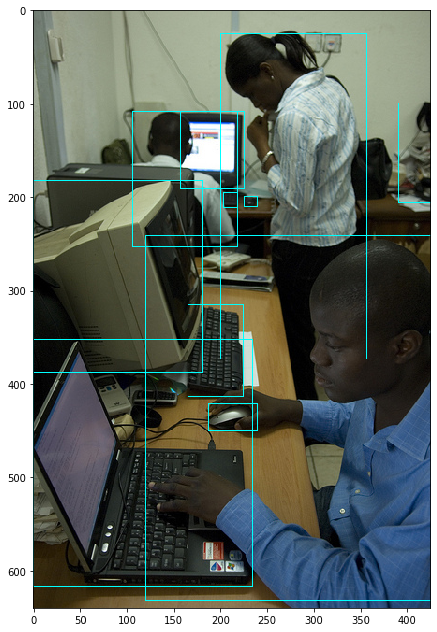

(291, 151) (398, 275)
(120, 68) (279, 255)
(90, 243) (238, 275)


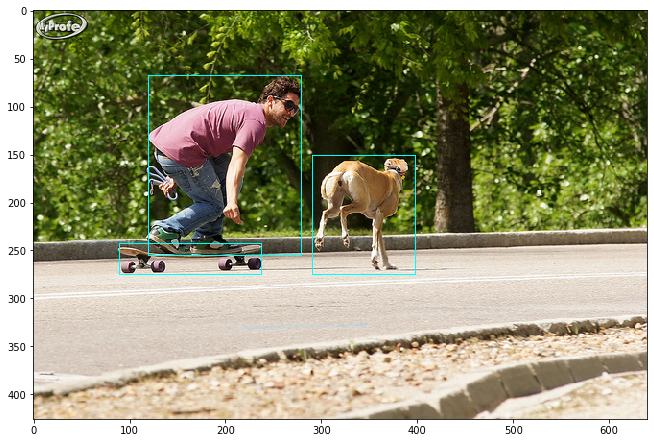

(130, 231) (271, 280)
(130, 232) (271, 279)
(129, 238) (162, 264)
(285, 4) (345, 363)
(177, 169) (242, 242)


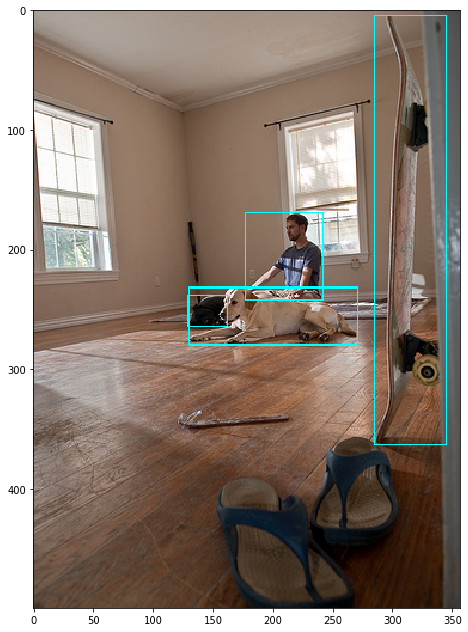

(159, 40) (525, 486)
(396, 1) (611, 487)
(11, 2) (145, 217)
(0, 4) (55, 251)
(135, 359) (459, 587)
(279, 2) (326, 57)
(283, 0) (364, 55)


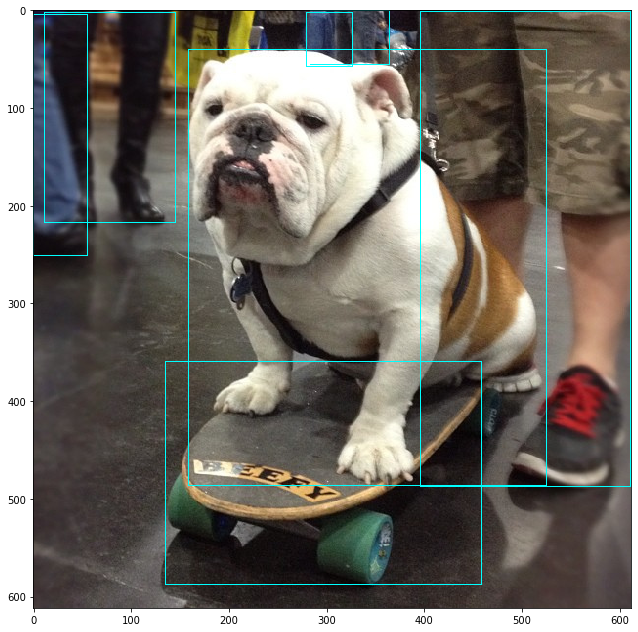

In [56]:
for img, lab in zip(imgs, new_labels):
    cv2_img_bgr = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)
    font = cv2.FONT_ITALIC
    for box in lab:
        print((box[0], box[1]), (box[2], box[3]))
        cv2.rectangle(cv2_img_bgr, (box[0], box[1]), (box[2], box[3]), (255, 255, 0), 1)
    img_rgb = cv2.cvtColor(cv2_img_bgr, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=[11, 11])
    ax = fig.add_subplot(111)
    ax.imshow(img_rgb)
    # ax.axis('off')
    plt.show()

(78, 214) (181, 387)
(200, 214) (346, 373)
(106, 214) (218, 253)
(346, 214) (346, 214)
(78, 352) (234, 426)
(187, 421) (239, 426)
(165, 315) (224, 413)
(157, 214) (225, 214)
(225, 214) (239, 214)
(120, 241) (346, 426)
(203, 214) (218, 214)


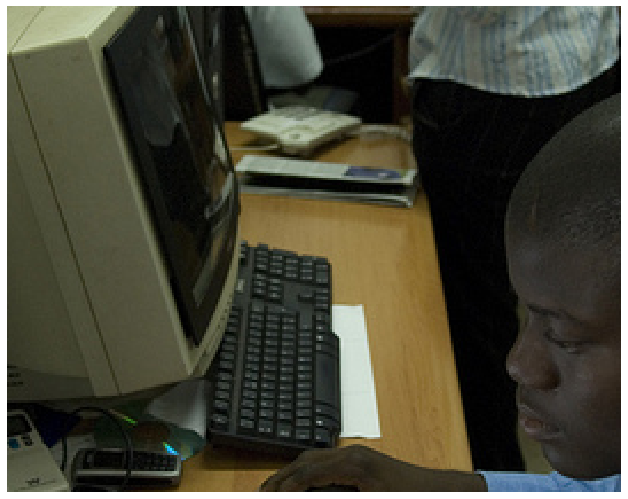

[[ 78 214 181 387]
 [200 214 346 373]
 [106 214 218 253]
 [346 214 346 214]
 [ 78 352 234 426]
 [187 421 239 426]
 [165 315 224 413]
 [157 214 225 214]
 [225 214 239 214]
 [120 241 346 426]
 [203 214 218 214]]
0 0
(291, 151) (398, 275)
(198, 107) (279, 255)
(198, 243) (238, 275)


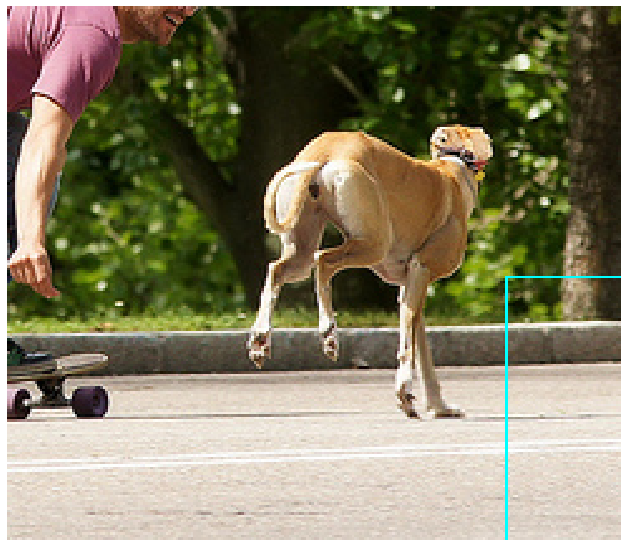

[[559 151 666 275]
 [466 107 547 255]
 [466 243 506 275]]
268 0
(130, 231) (271, 280)
(130, 232) (271, 279)
(129, 238) (162, 264)
(285, 100) (312, 363)
(177, 169) (242, 242)


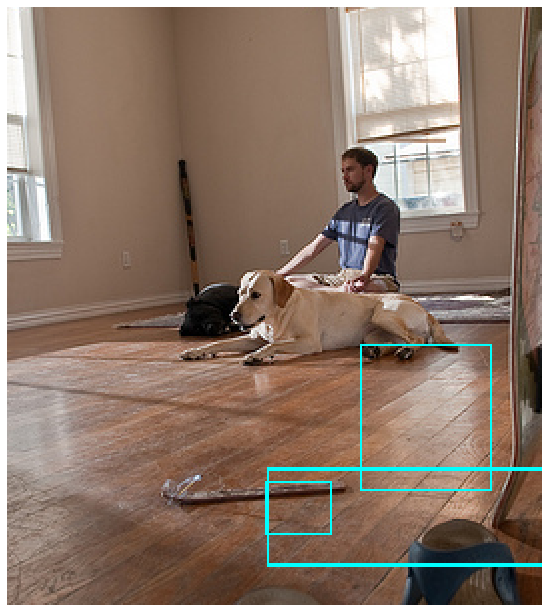

[[130 443 271 492]
 [130 444 271 491]
 [129 450 162 476]
 [285 312 312 575]
 [177 381 242 454]]
0 212
(184, 156) (428, 456)
(396, 156) (428, 456)
(184, 156) (184, 217)
(184, 156) (184, 251)
(184, 359) (428, 456)
(279, 156) (326, 156)
(283, 156) (364, 156)


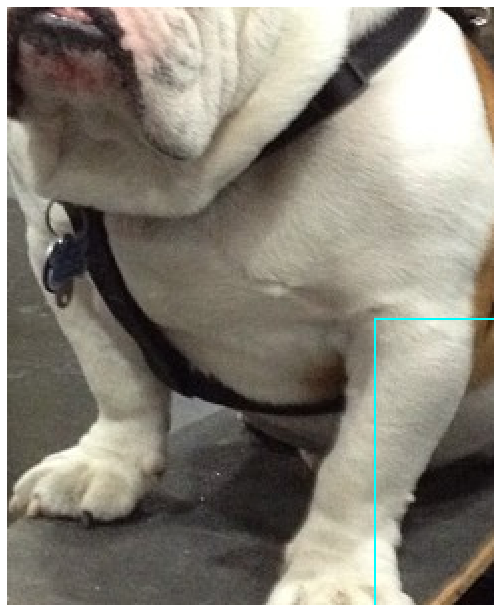

[[452 368 696 668]
 [664 368 696 668]
 [452 368 452 429]
 [452 368 452 463]
 [452 571 696 668]
 [547 368 594 368]
 [551 368 632 368]]
268 212


In [57]:
img, lab = mosaic(imgs, new_labels, [512, 512])

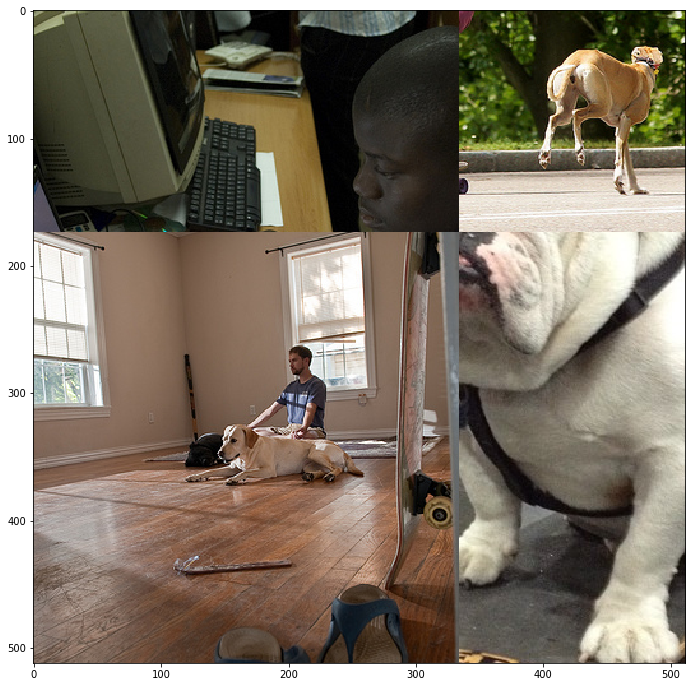

In [10]:
plt.figure(figsize=[12, 12])
plt.imshow(img)

In [12]:
lab

array([[ 45, 233, 181, 387],
       [200, 233, 356, 373],
       [106, 233, 218, 253],
       [ 45, 352, 234, 407],
       [165, 315, 224, 407],
       [120, 241, 379, 407],
       [130, 405, 271, 454],
       [130, 406, 271, 453],
       [129, 412, 162, 438],
       [285, 255, 345, 512],
       [177, 343, 242, 416]])

(45, 233) (181, 387)
(200, 233) (356, 373)
(106, 233) (218, 253)
(45, 352) (234, 407)
(165, 315) (224, 407)
(120, 241) (379, 407)
(130, 405) (271, 454)
(130, 406) (271, 453)
(129, 412) (162, 438)
(285, 255) (345, 512)
(177, 343) (242, 416)


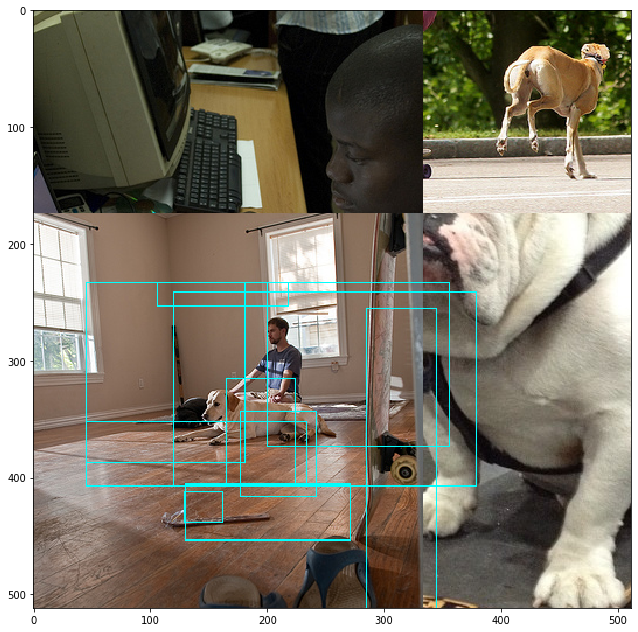

In [19]:
import cv2

cv2_img_bgr = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)
font = cv2.FONT_ITALIC
for box in lab:
    print((box[0], box[1]), (box[2], box[3]))
    cv2.rectangle(cv2_img_bgr, (box[0], box[1]), (box[2], box[3]), (255, 255, 0), 1)
img_rgb = cv2.cvtColor(cv2_img_bgr, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=[11, 11])
ax = fig.add_subplot(111)
ax.imshow(img_rgb)
# ax.axis('off')
plt.show()